# Project 4 : Kaggle West Nile Virus

----------

## Contents:
### Part 3 Cost and Benefit Analysis

1. [Importing Libraries](#1.-Importing-Libraries)
2. [Importing Data](#2.-Importing-Data)
3. [Cost and Benefits Analysis](#3.-Cost-and-Benefits-Analysis)
4. [Conclusion](#4.-Conclusion)
5. [Recommendations](#5.-Recommendations)
6. [Limitations and Next Steps](#6.-Limitations-and-Next-Steps)
-------

## 1. Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity

from sklearn.metrics import confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay

import pickle

# Display full output 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

## 2. Importing Data

In [6]:
spray = pd.read_pickle('./data/spray.pk1')
combine_train = pd.read_pickle('./data/combine_train.pk1')
test = pd.read_pickle('./data/final_test.pk1')

In [7]:
combine_train.head()

,date,species,block,street,trap,latitude,longitude,addressaccuracy,wnvpresent,nummosquitos,year,month,day,sunrise,sunset,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,rain,mist
0,2007-05-29,CULEX PIPIENS,22,W 89TH ST,T096,41.731922,-87.677512,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
1,2007-05-29,CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,41.867108,-87.654224,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
2,2007-05-29,CULEX PIPIENS/RESTUANS,21,N STAVE ST,T050,41.919343,-87.694259,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,22,N CANNON DR,T054,41.921965,-87.632085,8,0,2,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0
4,2007-05-29,CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,41.688324,-87.676709,8,0,1,2007,5,29,421.0,1917.0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,0.0,29.415,30.1,5.8,17.0,6.95,0.0,1.0


In [8]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14835 non-null  datetime64[ns]
 1   latitude   14835 non-null  float64       
 2   longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 347.8 KB


## 3. Cost and Benefits Analysis
We will be performing the relevant analysis on two separate approaches:

1. Analyzing the current approach taken by the State of Chicago in "containing" the WNV virus as the baseline approach
2. Compare it with our data-driven approach, which we believe is a more preventive approach rather than reactive

According to Kaggle website, every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations. We will next analyze the spray dataset given and hopefully it gives us some validation to the statement here.

In [9]:
spray['date'].unique()

array(['2011-08-29T00:00:00.000000000', '2011-09-07T00:00:00.000000000',
       '2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

Observation: From the spray dataset, it seems like in year 2011, there are only 2 separate period of spraying and for year 2013, the spraying activity is alot more frequent.  We are not sure if this is due to data availability issue but lets dive in further.

In [10]:
spray['date'].unique()[:2]

array(['2011-08-29T00:00:00.000000000', '2011-09-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [11]:
spray['date'].unique()[2:]

array(['2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [12]:
spray_2011 = spray['date'].unique()[:2]
spray_2013 = spray['date'].unique()[2:]

In [13]:
wnvpresent_2011 = combine_train[combine_train['date'].dt.year==2011].groupby('date')['wnvpresent'].sum()
wnvpresent_2013 = combine_train[combine_train['date'].dt.year==2013].groupby('date')['wnvpresent'].sum()

In [14]:
wnvpresent_2011

date
2011-06-10    0
2011-06-17    0
2011-06-24    0
2011-06-30    0
2011-07-11    0
2011-07-15    0
2011-07-25    3
2011-07-29    7
2011-08-05    4
2011-08-12    7
2011-08-19    3
2011-08-26    4
2011-09-01    4
2011-09-02    3
2011-09-12    6
2011-09-16    3
2011-09-23    6
2011-09-30    0
Name: wnvpresent, dtype: int64

In [15]:
nomosquitos_2011 = combine_train[combine_train['date'].dt.year==2011].groupby('date')['nummosquitos'].sum()
nomosquitos_2013 = combine_train[combine_train['date'].dt.year==2013].groupby('date')['nummosquitos'].sum()

Here, we would like to see how the spraying activity coincide with the number of mosquitos captured and also the detection of WNV virus presence.

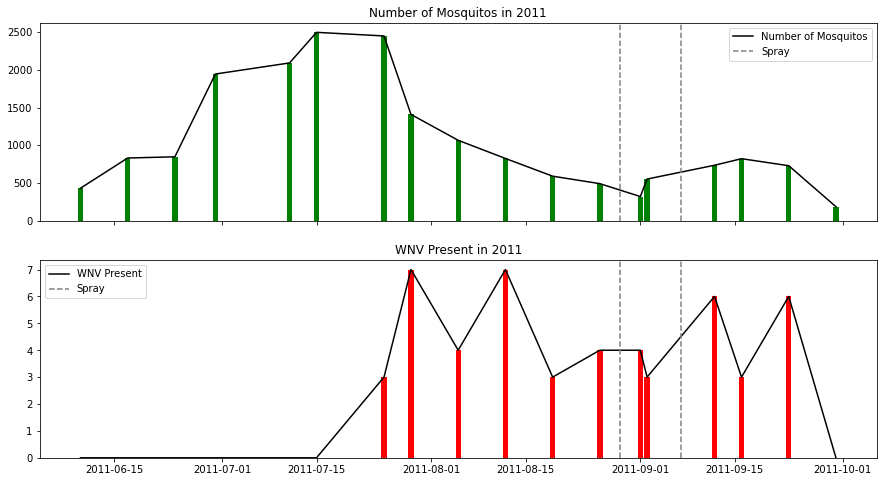

In [16]:
fig, axes = plt.subplots(nrows=2,sharex=True, figsize=(15,8))

axes[0].bar(nomosquitos_2011.index,nomosquitos_2011.values,color='green')
axes[0].plot(nomosquitos_2011.index,nomosquitos_2011.values,color='black')
for spray_date in spray_2011:
    axes[0].axvline(x=spray_date, color='grey', ls='--')
axes[0].set_title('Number of Mosquitos in 2011')
axes[0].legend(['Number of Mosquitos','Spray']);

axes[1].bar(wnvpresent_2011.index,wnvpresent_2011.values, color='red')
axes[1].plot(wnvpresent_2011.index,wnvpresent_2011.values, color='black')
for spray_date in spray_2011:
    axes[1].axvline(x=spray_date, color='grey', ls='--')
axes[1].set_title('WNV Present in 2011')
axes[1].legend(['WNV Present','Spray']);

With the available data for year 2011, we can see that there are separate period (in September) of spraying and at least from the graph, we can see the number of mosquitos taper off after the spraying (there could be time-lag effect which we can't really be sure).  Next we look at year 2013 data.

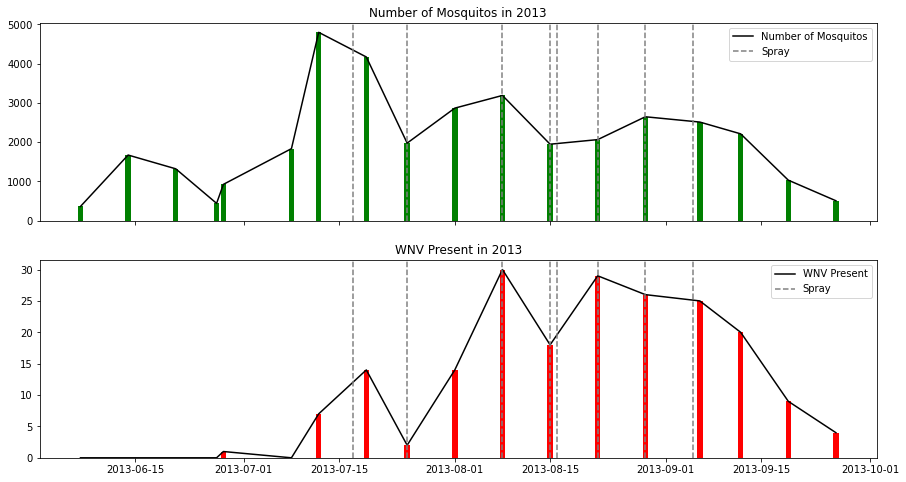

In [17]:
fig, axes = plt.subplots(nrows=2,sharex=True, figsize=(15,8))

#plot num mosquitos in 2013 against spray dates
axes[0].plot(nomosquitos_2013.index,nomosquitos_2013.values, color='black')
axes[0].bar(nomosquitos_2013.index,nomosquitos_2013.values, color='green')
for spray_date in spray_2013:
    axes[0].axvline(x=spray_date, color='grey', ls='--')
axes[0].set_title('Number of Mosquitos in 2013')
axes[0].legend(['Number of Mosquitos','Spray']);

#plot wnv in 2013 against spray dates
axes[1].plot(wnvpresent_2013.index,wnvpresent_2013.values, color='black')
axes[1].bar(wnvpresent_2013.index,wnvpresent_2013.values, color='red')
for spray_date in spray_2013:
    axes[1].axvline(x=spray_date, color='grey', ls='--')
axes[1].set_title('WNV Present in 2013')
axes[1].legend(['WNV Present','Spray']);

Here we have a lot more insights.  For year 2013, it seems like the spraying effect is alot more apparent in some cases.  For example, in July 15, right after the spray, we can see both the number of mosquitos as well as the WNV detected cases tapered off right after.  However, we also have spraying event which took place sometime in 15th of August, whic resulted to another peak in both numbers as well as WNV presence.  We can't really conclude the effectiveness of the spraying activity but it does validate the strategy taken by State of Chicago stated on Kaggle page, which is more reactive.

Based on research gathered from some website like below, State of Chicago seems to be using some chemical by the name of Zenivex.  To make things simple, we assume the price of Zenivex E4 is $1.0 per acre and each location (with the specify latitude and longitude) covers an area of 100 acres.

https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes0.html

In [18]:
spray.drop_duplicates(inplace=True)

In [19]:
spray.head()

,date,latitude,longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [20]:
filtered_df = spray.loc[(spray['date'] >= '2011-10-01')]

In [21]:
filtered_df.tail()

,date,latitude,longitude
14830,2013-09-05,42.006587,-87.812355
14831,2013-09-05,42.006192,-87.816015
14832,2013-09-05,42.006022,-87.817392
14833,2013-09-05,42.005453,-87.817423
14834,2013-09-05,42.004805,-87.817460


In [22]:
filtered_df.date.unique()

array(['2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

Note: Taking year 2013 spray dataset as our reference and baseline approach (using the assumption made earlier on the price and acres coverage of each location) the total cost is (12626x1.0x100)= $1,262,600

Next, we will work out the details on the data-driven predictive approach.  By using the whole training dataset, for backtesting purposes, we run the it against our selected production model.  As we have taken a zero tolerance to false negative cases here, we firstly run thru the various threshold to achieve a close to 1 recall score.  Based on that, we gathered the total predicted WNV positive cases and used that as the basis to guide our spraying strategy.  This would also include higher false positive cases as a tradeoff to having zero case for false negative.

In [23]:
#loading back xgb model
loaded_xgb = pickle.load(open("./data/xgb_trained.pickle.dat", "rb"))

In [24]:
X_train = pd.read_pickle('./data/final_train.pk1')

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   month_dewpoint            8610 non-null   float64
 1   species_dewpoint          8610 non-null   float64
 2   nightime_dewpoint         8610 non-null   float64
 3   species                   8610 non-null   float64
 4   month                     8610 non-null   int64  
 5   dewpoint                  8610 non-null   float64
 6   wetbulb                   8610 non-null   float64
 7   tmin                      8610 non-null   float64
 8   tavg                      8610 non-null   float64
 9   nighttime                 8610 non-null   float64
 10  longitude                 8610 non-null   float64
 11  cool                      8610 non-null   float64
 12  trap_T900                 8610 non-null   uint8  
 13  street_ W OHARE AIRPORT   8610 non-null   uint8  
 14  depart  

In [26]:
X_train[X_train['year'] == 2013].head()

,month_dewpoint,species_dewpoint,nightime_dewpoint,species,month,dewpoint,wetbulb,tmin,tavg,nighttime,longitude,cool,trap_T900,street_ W OHARE AIRPORT,depart,tmax,heat,resultspeed,year,street_ N OAK PARK AVE,street_ N MILWAUKEE AVE,trap_T003,avgspeed,trap_T225,street_ S KOSTNER AVE,trap_T143,trap_T086,street_ W 113TH ST,latitude,rain,trap_T002,trap_T223,street_ N MONT CLARE AVE,street_ N AVONDALE AVE,trap_T006,trap_T046,street_ W GRAND AVE,street_ S DOTY AVE,trap_T115,trap_T233
6552,267.0,89.0,400.5,2.0,6,44.5,52.0,53.0,60.5,9.0,-87.600880,0.0,0,0,-6.0,68.0,4.5,9.15,2013,0,0,0,9.55,0,0,0,0,0,41.773215,0.0,0,0,0,0,0,0,0,0,0,0
6553,267.0,89.0,400.5,2.0,6,44.5,52.0,53.0,60.5,9.0,-87.585413,0.0,0,0,-6.0,68.0,4.5,9.15,2013,0,0,0,9.55,0,0,0,0,0,41.726465,0.0,0,0,0,0,0,0,0,0,0,0
6554,267.0,89.0,400.5,2.0,6,44.5,52.0,53.0,60.5,9.0,-87.649970,0.0,0,0,-6.0,68.0,4.5,9.15,2013,0,0,0,9.55,0,0,0,0,0,41.723195,0.0,0,0,0,0,0,0,0,0,0,0
6555,267.0,89.0,400.5,2.0,6,44.5,52.0,53.0,60.5,9.0,-87.930995,0.0,0,0,-6.0,68.0,4.5,9.15,2013,0,0,0,9.55,0,0,0,0,0,41.957799,0.0,0,0,0,0,0,0,0,0,0,0
6556,267.0,89.0,400.5,2.0,6,44.5,52.0,53.0,60.5,9.0,-87.890615,0.0,1,1,-6.0,68.0,4.5,9.15,2013,0,0,0,9.55,0,0,0,0,0,41.974689,0.0,0,0,0,0,0,0,0,0,0,0


In [27]:
y_train = combine_train['wnvpresent']

In [28]:
def get_predictions(pred_proba, threshold): # define custom function to accept 2 args, prediction probabilities & threshold
    return [0 if prob < threshold else 1 for prob in pred_proba] # list comprehension to return custom threshold based on probability

Threshold: 0.25, Recall score: 1.0
Threshold: 0.25, Precision score: 0.14924885695623774
Threshold: 0.4, Recall score: 0.9912472647702407
Threshold: 0.4, Precision score: 0.1917054591620821
Threshold: 0.5, Recall score: 0.9606126914660832
Threshold: 0.5, Precision score: 0.22093608454957223
Threshold: 0.6, Recall score: 0.888402625820569
Threshold: 0.6, Precision score: 0.2579415501905972
Threshold: 0.75, Recall score: 0.6892778993435449
Threshold: 0.75, Precision score: 0.32778355879292403


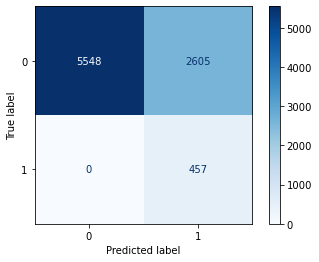

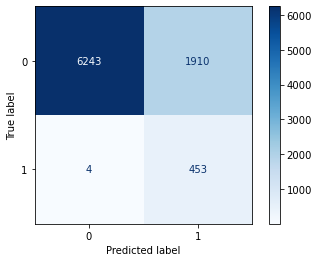

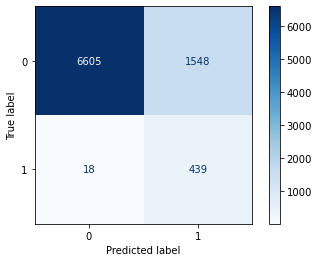

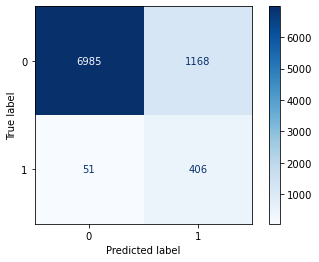

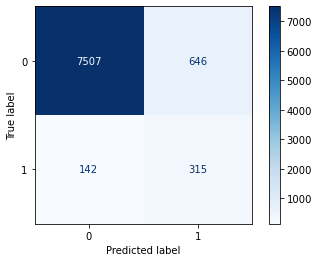

In [29]:
# simulating experiment with a few thresholds to trial optimal score for model 
threshold_list = [0.25, 0.4, 0.5, 0.6, 0.75]

for threshold in threshold_list:
    preds = get_predictions(pred_proba=loaded_xgb.predict_proba(X_train)[:,1], threshold=threshold) # get predictions based on custom threshold
    cm = confusion_matrix(y_train, preds)
    recall = recall_score(y_train, preds)
    print(f'Threshold: {threshold}, Recall score: {recall}')
    precision = precision_score(y_train, preds)
    print(f'Threshold: {threshold}, Precision score: {precision}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')

From here, we shall take the threshold of 0.25 and from the confusion matrix, we can see that there is a zero case false negative.  Taking the total predicted positive cases, we have (2605+457) = 3062 "predicted" positive area to work on using this backtesting methodology.  As observed, the cost of spray is definitely more economical as compared to the current approach taken by Chicago (baseline approach taking year 2013 as reference) and we have chosen a conservative threshold to omit any false negative cases.  Beside the cost perspective (mainly considering spray cost), this approach is more preventive as we have taken all dimension of data available to us like weather and others to make a forecast of where could be the likely problematic region, considering time factor and act upon it.  However, we would suggest doing a A/B testing on the various model threshold against existing baseline approach and execute the strategy real-time in the coming years to further validate the outcome.

In [30]:
def roc_curve_plotter(m):
    RocCurveDisplay.from_estimator(m, X_train, y_train)


    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

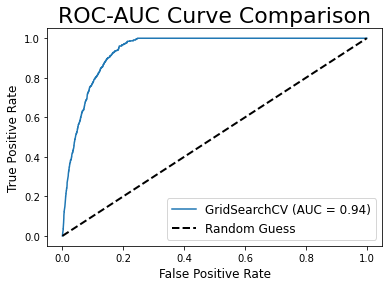

In [31]:
roc_curve_plotter(loaded_xgb)

In [32]:
test_predictions = loaded_xgb.predict_proba(test)
pred_proba_t = [i[1] for i in test_predictions]

In [33]:
test = pd.DataFrame(data = test)
test['wnvpresent_25'] = [1 if p> 0.25 else 0 for p in pred_proba_t]

### Additional Analysis

Other than the presence of WNV and mosquito populations it is also important to consider population of the city before determining suitable areas for fogging. For example, the benefits of fogging areas with high population density  is likely to outweigh costs since it would provide protection to a large number of residents as compared to areas with low pop density. To do this we will be bringing in additional data points on Chicago population by location.

In [56]:
#Us Zip code data
zips= pd.read_csv("./data/uszips.csv")

In [57]:
# Chicago population data
pop = pd.read_csv("./data/Chicago_Population_Counts.csv")

In [58]:
#converting population data into an abridged df
pop_df = pd.DataFrame(data = pop[['Geography', 'Population - Total']])

In [59]:
pop_df.head()

,Geography,Population - Total
0,Chicago,"2,705,988"
1,60601,"14,675"
2,60602,"1,244"
3,60603,"1,174"
4,60604,782


In [60]:
#droping 1st row that is for the entire chicago that we dont need
pop_df.drop(index = 0, inplace = True)

In [61]:
#there is another item somewhere ard row 60 we'll drop that as well.
pop_df.drop(index = [index for index in [pop_df[pop_df.Geography== 'Chicago'].index[0]]], inplace = True)

In [62]:
# converting zipcode to integers
pop_df.Geography = [int(zip) for zip in pop_df.Geography]

In [63]:
#resettign index
pop_df.reset_index(inplace = True, drop = True)

In [64]:
# Creating empty columns
pop_df['lat'] = ''
pop_df['lng'] = ''

In [65]:
# setting county location to based on zipcode
for index, row in pop_df.iterrows():
    try:
        lat = zips[zips.zip == row.Geography].lat.values[0]
        lon = zips[zips.zip == row.Geography].lng.values[0]

        pop_df.at[index, "lat"] = lat
        pop_df.at[index, "lng"] = lon
    except:
        pop_df.at[index, "lat"] = 0
        pop_df.at[index, "lng"] = 0

In [66]:
# converting pop size to numbers
pop_df['pop_total'] = [int(total.replace(',','')) for total in pop_df['Population - Total']]

In [67]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Geography           118 non-null    int64 
 1   Population - Total  118 non-null    object
 2   lat                 118 non-null    object
 3   lng                 118 non-null    object
 4   pop_total           118 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.7+ KB


In [68]:
# converting to population number in thousands instead of actual figure
pop_df['pop_total'] = [int(total/1000) for total in pop_df['pop_total']]

In [69]:
pop_df.head()

,Geography,Population - Total,lat,lng,pop_total
0,60601,"14,675",41.88526,-87.62194,14
1,60602,"1,244",41.88309,-87.62912,1
2,60603,"1,174",41.88022,-87.62549,1
3,60604,782,41.87814,-87.62837,0
4,60605,"27,519",41.86684,-87.61983,27


In [70]:
combine_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             8610 non-null   datetime64[ns]
 1   species          8610 non-null   object        
 2   block            8610 non-null   int64         
 3   street           8610 non-null   object        
 4   trap             8610 non-null   object        
 5   latitude         8610 non-null   float64       
 6   longitude        8610 non-null   float64       
 7   addressaccuracy  8610 non-null   int64         
 8   wnvpresent       8610 non-null   int64         
 9   nummosquitos     8610 non-null   int64         
 10  year             8610 non-null   int64         
 11  month            8610 non-null   int64         
 12  day              8610 non-null   int64         
 13  sunrise          8610 non-null   float64       
 14  sunset           8610 non-null   float64

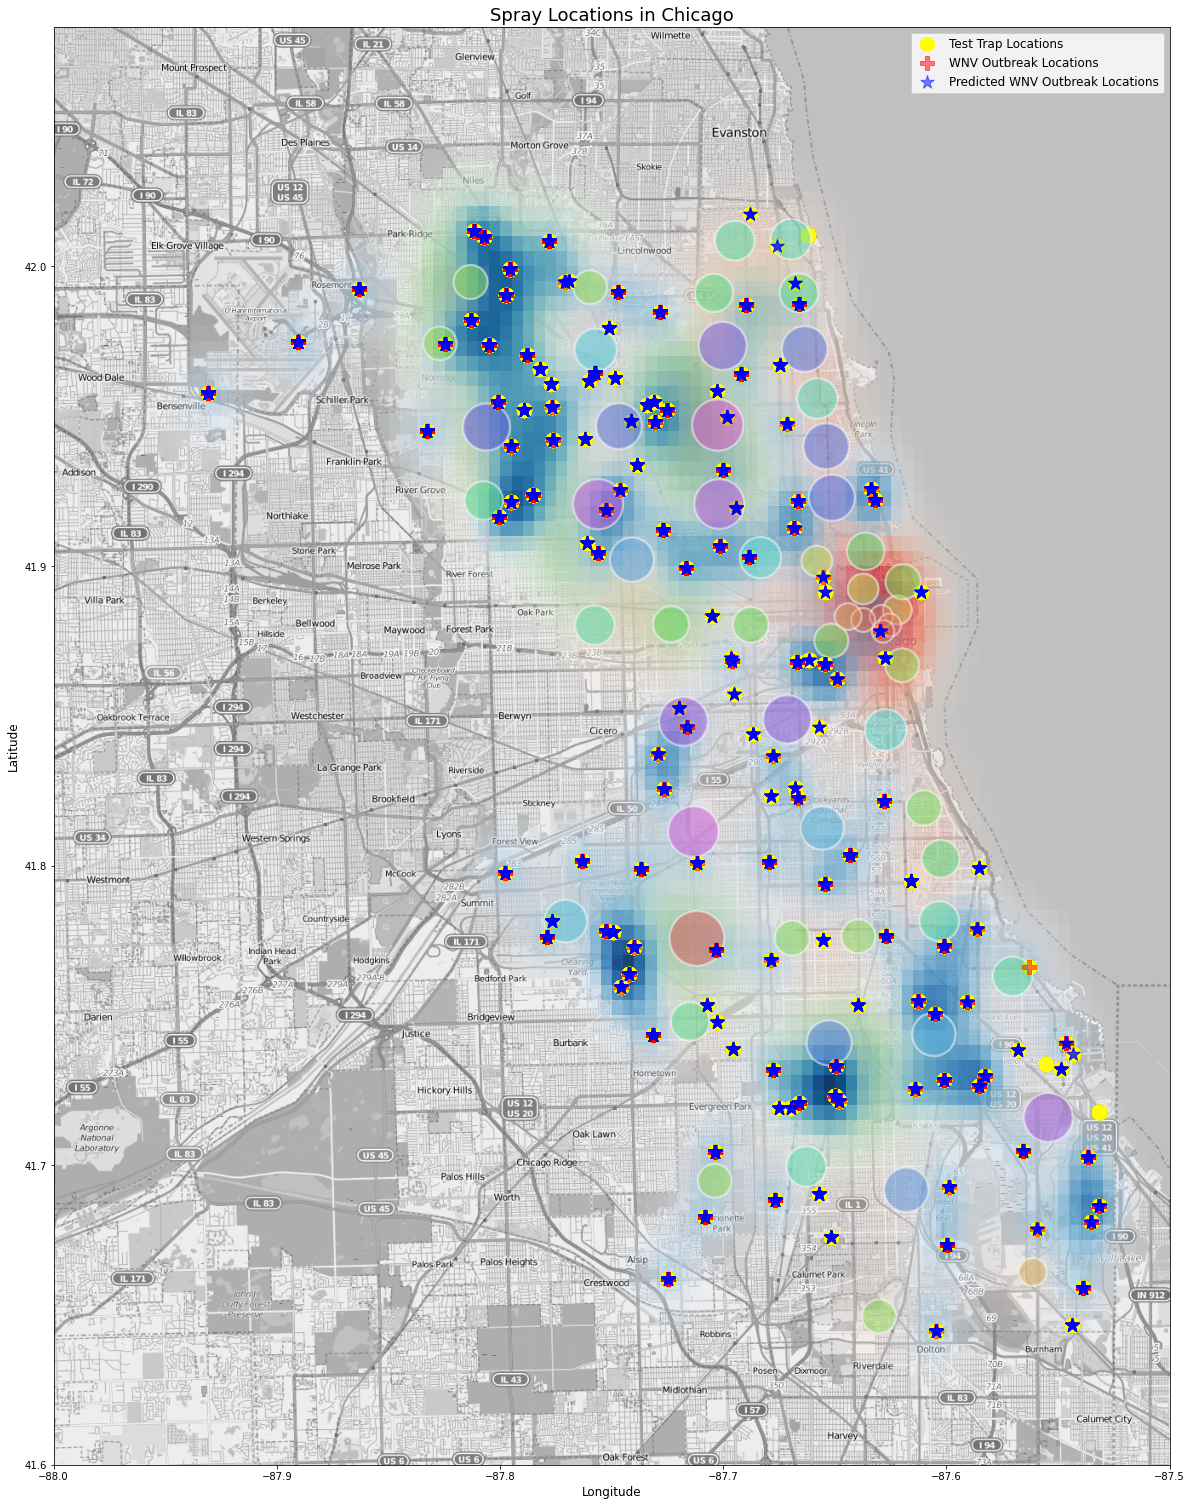

In [88]:
#kernal density for spray patterns
alpha_cm = plt.cm.Greens
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]

#density for population centres
alpha_cm2 = plt.cm.Reds
alpha_cm2._init()
alpha_cm2._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm2.N) / 10 - 1)[::-1]

#density for locations with WNV is predicted
alpha_cm3 = plt.cm.Blues
alpha_cm3._init()
alpha_cm3._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm3.N) / 10 - 1)[::-1]

# plot locations of traps and instances of WNV cases
mapdata = np.loadtxt("./assets/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)



# Spray location
X = spray[['longitude', 'latitude']].drop_duplicates().values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

# pop info
X2 = pop_df[['lng', 'lat']].drop_duplicates().values

kd2 = KernelDensity(bandwidth=0.015)
kd2.fit(X2)

#wnv_density
X3 = combine_train[combine_train.wnvpresent == 1][['longitude', 'latitude']].drop_duplicates().values

kd3 = KernelDensity(bandwidth=0.01)
kd3.fit(X3)


#spray area
xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#polulation areas
xv2,yv2 = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints2 = np.array([xv2.ravel(),yv2.ravel()]).T
zv2 = np.exp(kd2.score_samples(gridpoints2).reshape(100,100))

#WNV detection areas
xv3,yv3 = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints3 = np.array([xv3.ravel(),yv3.ravel()]).T
zv3 = np.exp(kd3.score_samples(gridpoints2).reshape(100,100))

#kernel density
plt.figure(figsize=(20,28))
plt.imshow(mapdata, cmap = plt.get_cmap('gray'), extent = lon_lat_box, aspect = aspect)


plt.imshow(zv, origin = 'lower', cmap = alpha_cm, extent = lon_lat_box, aspect = aspect)


plt.imshow(zv2, origin = 'lower', cmap = alpha_cm2, extent = lon_lat_box, aspect = aspect)

plt.imshow(zv3, origin = 'lower', cmap = alpha_cm3, extent = lon_lat_box, aspect = aspect)

# trap locations
#trap_locations = train[['longitude', 'latitude']].values
#plt.scatter(trap_locations[:,0], trap_locations[:,1], marker = 'o', c = 'b', label = 'Trap Locations')

trap_location_test = test[['longitude', 'latitude']].values
plt.scatter(trap_location_test[:,0], trap_location_test[:,1], marker = 'o', c = 'yellow', label = 'Test Trap Locations', s = 200)

#population centres
sns.scatterplot(x= pop_df.lng, y = pop_df.lat, hue = pop_df.pop_total, palette = 'hls', alpha = 0.3, hue_order = [0,20,40,60,80,100],size = pop_df.pop_total,  sizes = (500, 3000), legend = False)

# wnn outbreak locations
wnv_locations = combine_train[combine_train['wnvpresent'] != 0][['longitude', 'latitude']].values
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker = 'P', c = 'r', label = 'WNV Outbreak Locations', s = 200, alpha = 0.5)

# predicted wnn outbreak locations
wnv_locations_predicted = test[test['wnvpresent_25'] != 0][['longitude', 'latitude']].values
plt.scatter(wnv_locations_predicted[:,0], wnv_locations_predicted[:,1], marker = '*', c = 'blue', label = 'Predicted WNV Outbreak Locations', s = 200, alpha = 0.5)



plt.ylim(41.6, 42.08)

plt.xlim(-88, -87.5)

plt.title('Spray Locations in Chicago', fontsize = 18)
plt.legend(fontsize = 12)
plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)
plt.savefig('./image/Spray_Locations_2.png')

## 4. Conclusion

Among our four models that we tuned (Xgboost, Adaboost, logistic Regression and Random Forest, XGBoost had the best performance as measured by AUC on the validation dataset.

Considering that we intend to use the model to predict potential West Nile Virus hotspots, the model should ideally achieve zero false negatives. Referring back the ROC curve from earlier we see that the optimal classification threshold is about 0.4 where the slope of the curve flattens out and we start seeing our TPR rising at marginal levels. However, using a classification threshold of 0.4 in a small number of false negatives. By lowering our classification threshold down to 0.25 we can lower our false negatives to zero while only lowering our TPR to ~0.8.

While a 20% error rate is not ideal, it is important to note that mosquito's typically travel 1-3 miles and a certain level of 'overspraying' is expected. In addition, spraying of misclassified areas will at least have the benefit of keeping mosquito populations low and it is expected that benefits are likely to outweigh costs as the added spray areas are near/ within residential areas.



## 5. Recommendations

Using our selected model we have identified that features relating to weather and location are the strongest predictors of the presence WNV.

At the selected threshold a significant majority of locations are identified as potential hotspots and spraying insecticide across all identified areas would essentially require city wide fogging that is not operationally and financially feasible.

Instead of preventing outbreaks across the entire city throughout the year, it would be more prudent to focus on areas with high resident populations, since the main detriments of a WNV outbreak are related to the cost of treatment and reduced economic output from worker absence and shocks to healthcare system.

Referring to our earlier plot of Chicago we can see that there when we overlay trap predicted and past locations where WNV was detected against population centres in Chicago, we recommend the following:

- a portion of predicted/ histroical locations with WNV present are located away from population centres. These areas should be skipped as benefit of spraying these areas is likely to be marginal considering the low resident population.

- Based on data on hand spraying done in the northern portion of Chicago is ideal as it effectively covers several population centres and wnv hotspots.

- To extend protection in this area frequency of fogging should be increased to cover the entirety of summer into mid September when temperatures start to fall.

- In addition other vector controls can be considered to remove breeding habitats between the months of May to June tackle the rise is mosquito populations typically seen in the summer months.

- Fogging activities should be expanded to cover hotspots in the southern portion of Chicago where there are several spots where the model predicts WNV that fall within population centres.

- Trap density in downtown Chicago is relatively low considering that a significant number of people work/reside in the area more traps should be put in the area to accurately assess the risk of the area.


## 6. Limitations and Next Steps

Moving forward, geographical and more human demographic data can be incorporated into the model. Considering that mosquito's are a necessary component for the transmission of WNV, studying geographical data on bodies of water in the vicinity of Chicago would likely be very useful to evaluate the impact of the lack off/presence of breeding habitats on the presence of WNV.